### CIFAR10 Dataset and DataLoader Creation. Simple CNN Model Creation


In [1]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

tr_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - tr_size
tr_dataset, val_dataset = random_split(train_dataset, [tr_size, val_size])
print('tr:', len(tr_dataset), 'valid:', len(val_dataset))

tr_loader = DataLoader(tr_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:02<00:00, 59.5MB/s]


tr: 42500 valid: 7500


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchinfo import summary

NUM_INPUT_CHANNELS = 3

class SimpleCNNWithBN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_block_1 = self.create_convbn_block(first_channels=3, middle_channels=32, last_channels=32)

        self.conv_block_2 = self.create_convbn_block(first_channels=32, middle_channels=64, last_channels=64)

        self.conv_block_3 = self.create_convbn_block(first_channels=64, middle_channels=128, last_channels=128)

        self.classifier_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def create_convbn_block(self, first_channels, middle_channels, last_channels):
        conv_bn_block = nn.Sequential(
            nn.Conv2d(in_channels=first_channels, out_channels=middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=middle_channels, out_channels=last_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(last_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        return conv_bn_block

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier_block(x)

        return x

def create_do_classifier_block(first_features, second_features, first_dos, second_dos, num_classes=10):
    return nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=first_dos),
            nn.Linear(in_features=first_features, out_features=second_features),
            nn.ReLU(),
            nn.Dropout(p=second_dos),
            nn.Linear(in_features=second_features, out_features=num_classes),
        )


### Various Learning Rate Schedulers

* PyTorch provides various types of learning rate scheduler classes in `torch.optim.lr_scheduler`.
* Some schedulers adjust the learning rate based on a validation metric, changing it each epoch according to specified conditions, while others change the learning rate following a preset pattern without using a validation metric.
* `ReduceLROnPlateau` usually relies on a validation metric (e.g., loss). It monitors the metric at each epoch, and if the metric stops improving, it reduces the learning rate at the next training epoch.
* Schedulers like `StepLR`, `CyclicLR`, and `CosineAnnealingLR` adjust the learning rate periodically according to a predefined pattern.


### Creating and Applying a Learning Rate Scheduler

* A learning rate (LR) scheduler requires an `Optimizer` object at initialization. This allows the scheduler to directly access the optimizer-managed parameters related to learning rate. Any LR changes must go through the optimizer.
* The LR scheduler updates the learning rate by calling its `step()` method.
* `scheduler.step()` should be called once per epoch (not per batch) and **after** `optimizer.step()`.
* The current learning rate can be checked from the optimizer via `optimizer.param_groups[0]['lr']`, or from the scheduler using `scheduler.get_last_lr()[0]` or `scheduler.get_lr()[0]`.
* `scheduler.get_last_lr()[0]` returns the learning rate **after** the last `scheduler.step()` call (the currently applied LR), while `scheduler.get_lr()[0]` returns the learning rate **to be applied** in the next `scheduler.step()` call.


In [3]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

NUM_CLASSES = 10

sample_model = SimpleCNNWithBN(num_classes=NUM_CLASSES)
# learning rate scheduler needs an optimizer so make an optimizer first
optimizer = Adam(sample_model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

print('optimizer lr:', optimizer.param_groups[0]['lr'])#optimizer.param_groups[0].keys()
print('get_last_lr():', scheduler.get_last_lr()[0])
print('get_lr():', scheduler.get_lr()[0])

scheduler.step()

print('optimizer lr:', optimizer.param_groups[0]['lr'])#optimizer.param_groups[0].keys()
print('get_last_lr():', scheduler.get_last_lr()[0])
print('get_lr():', scheduler.get_lr()[0]) # next lr

optimizer lr: 0.01
get_last_lr(): 0.01
get_lr(): 0.01
optimizer lr: 0.005
get_last_lr(): 0.005
get_lr(): 0.0025


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:538: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [4]:
optimizer.param_groups[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused', 'initial_lr'])


### Modify the Trainer class to apply Learning Rate Scheduler

* `scheduler.step()` must be called at the end of each **epoch** (not per batch) and should be executed **after** `optimizer.step()`.
* `ReduceLROnPlateau` is (mostly) applied during the **validation epoch**, and you need to pass an evaluation metric (e.g., `val_loss`) as an argument like `scheduler.step(val_loss)`.
* Other LR schedulers are (mostly) applied during the **training epoch**, and they are executed simply by calling `scheduler.step()`.

In [5]:
from tqdm import tqdm
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, scheduler=None, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        # add scheduler
        self.scheduler = scheduler
        self.device = device
        # variable to store the current learning rate
        self.current_lr = self.optimizer.param_groups[0]['lr']

    def train_epoch(self, epoch):
        self.model.train()

        # calculate running average loss
        accu_loss = 0.0
        running_avg_loss = 0.0
        # accuracy metrics: total count and accumulated correct count
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        # visualize training loop progress in real time with tqdm
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                # must use to(self.device). not to(device).
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # calculate accumulated loss per batch and running average loss
                accu_loss += loss.item()
                running_avg_loss = accu_loss /(batch_idx + 1)

                # calculate accuracy metric
                # get number of correct predictions comparing outputs and targets
                num_correct = (outputs.argmax(-1) == targets).sum().item()
                # compute accuracy with total samples and accumulated correct predictions
                num_total += inputs.shape[0]
                accu_num_correct += num_correct
                accuracy = accu_num_correct / num_total

                # update tqdm progress bar with running average loss and accuracy
                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # update every 20 batches or at last batch
                    progress_bar.set_postfix({"Loss": running_avg_loss,
                                              "Accuracy": accuracy})
        # Do not apply ReduceLRPlateau during training, so check if it is not ReduceLRPlateau
        if(self.scheduler is not None) and (not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) ):
            self.scheduler.step()
            self.current_lr = self.scheduler.get_last_lr()[0]
            print("scheduler step() call")
        return running_avg_loss, accuracy

    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None

        self.model.eval()

        # calculate running average loss
        accu_loss = 0.0
        running_avg_loss = 0.0
        # accuracy metrics: total count and accumulated correct count
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    outputs = self.model(inputs)

                    loss = self.loss_fn(outputs, targets)
                    # calculate accumulated loss per batch and running average loss
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss /(batch_idx + 1)

                    # calculate accuracy metric
                    # get number of correct predictions comparing outputs and targets
                    num_correct = (outputs.argmax(-1) == targets).sum().item()
                    # compute accuracy with total samples and accumulated correct predictions
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    accuracy = accu_num_correct / num_total

                    # update tqdm progress bar with running average loss and accuracy
                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # update every 20 batches or at last batch
                        progress_bar.set_postfix({"Loss": running_avg_loss,
                                                  "Accuracy":accuracy})
        # for scheduler based on validation data, pass epoch-level loss as input
        if (self.scheduler is not None) and isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step(running_avg_loss)
            self.current_lr = self.scheduler.get_last_lr()[0]
            print("scheduler step(evaluation_value) call")

        return running_avg_loss, accuracy

    def fit(self, epochs):
        # create history dictionary to log train/validation results and learning rate per epoch
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}",
                  f", Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}" if val_loss is not None else "",
                  f", Current lr:{self.current_lr:.6f}")
            # log train/validation results and learning rate per epoch
            history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
            history['lr'].append(self.current_lr)

        return history

    # return the trained model
    def get_trained_model(self):
        return self.model



#### Training the Model Using a Trainer with Learning Rate Scheduler

* Main arguments of **ReduceLROnPlateau**:

  * **mode**: Either `'min'` or `'max'`.

    * `'min'` is used when smaller values indicate improvement (e.g., loss).
    * `'max'` is used when larger values indicate improvement (e.g., accuracy).
  * **factor**: The scaling value applied when adjusting the learning rate.

    * `new_lr = lr * factor`. Default is `0.1`.
  * **patience**: Number of epochs with no improvement before reducing the learning rate.

    * If the metric does not improve for more than `patience` epochs, the learning rate decreases.
  * **threshold**: The minimal change in the monitored metric to be considered as an actual improvement (small variations within this threshold are ignored).
  * **min\_lr**: The minimum learning rate allowed (the scheduler will not reduce LR further).
  * **cooldown**: Number of epochs to wait after a learning rate reduction before resuming normal operation of the scheduler.



In [6]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

NUM_INPUT_CHANNELS = 3
NUM_CLASSES = 10

model = SimpleCNNWithBN(num_classes=NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(
            optimizer=optimizer, mode='min', factor=0.5, patience=2, threshold=0.01, min_lr=0.00001)

trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer,
       train_loader=tr_loader, val_loader=val_loader, scheduler=scheduler, device=device)

history = trainer.fit(30)

Epoch 1 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 239.04it/s, Loss=0.987, Accuracy=0.649]


scheduler step(evaluation_value) call
Epoch 1/30, Train Loss: 1.2056 Train Accuracy: 0.5685 , Val Loss: 0.9867 Val Accuracy: 0.6488 , Current lr:0.001000


Epoch 2 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.38it/s, Loss=0.875, Accuracy=0.701]


scheduler step(evaluation_value) call
Epoch 2/30, Train Loss: 0.8266 Train Accuracy: 0.7090 , Val Loss: 0.8746 Val Accuracy: 0.7007 , Current lr:0.001000


Epoch 3 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 252.46it/s, Loss=0.68, Accuracy=0.758]


scheduler step(evaluation_value) call
Epoch 3/30, Train Loss: 0.6640 Train Accuracy: 0.7698 , Val Loss: 0.6796 Val Accuracy: 0.7583 , Current lr:0.001000


Epoch 4 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 247.21it/s, Loss=0.681, Accuracy=0.768]


scheduler step(evaluation_value) call
Epoch 4/30, Train Loss: 0.5645 Train Accuracy: 0.8061 , Val Loss: 0.6812 Val Accuracy: 0.7676 , Current lr:0.001000


Epoch 5 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.19it/s, Loss=0.607, Accuracy=0.787]


scheduler step(evaluation_value) call
Epoch 5/30, Train Loss: 0.4894 Train Accuracy: 0.8313 , Val Loss: 0.6070 Val Accuracy: 0.7873 , Current lr:0.001000


Epoch 6 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.92it/s, Loss=0.534, Accuracy=0.815]


scheduler step(evaluation_value) call
Epoch 6/30, Train Loss: 0.4266 Train Accuracy: 0.8519 , Val Loss: 0.5338 Val Accuracy: 0.8155 , Current lr:0.001000


Epoch 7 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.85it/s, Loss=0.541, Accuracy=0.819]


scheduler step(evaluation_value) call
Epoch 7/30, Train Loss: 0.3743 Train Accuracy: 0.8689 , Val Loss: 0.5411 Val Accuracy: 0.8187 , Current lr:0.001000


Epoch 8 [Validating]: 100%|██████████| 235/235 [00:01<00:00, 229.47it/s, Loss=0.603, Accuracy=0.803]


scheduler step(evaluation_value) call
Epoch 8/30, Train Loss: 0.3242 Train Accuracy: 0.8879 , Val Loss: 0.6027 Val Accuracy: 0.8028 , Current lr:0.001000


Epoch 9 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.77it/s, Loss=0.592, Accuracy=0.812]


scheduler step(evaluation_value) call
Epoch 9/30, Train Loss: 0.2850 Train Accuracy: 0.9006 , Val Loss: 0.5916 Val Accuracy: 0.8121 , Current lr:0.000500


Epoch 10 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 251.66it/s, Loss=0.477, Accuracy=0.843]


scheduler step(evaluation_value) call
Epoch 10/30, Train Loss: 0.1748 Train Accuracy: 0.9425 , Val Loss: 0.4770 Val Accuracy: 0.8428 , Current lr:0.000500


Epoch 11 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 251.19it/s, Loss=0.522, Accuracy=0.842]


scheduler step(evaluation_value) call
Epoch 11/30, Train Loss: 0.1402 Train Accuracy: 0.9548 , Val Loss: 0.5222 Val Accuracy: 0.8424 , Current lr:0.000500


Epoch 12 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 249.33it/s, Loss=0.544, Accuracy=0.846]


scheduler step(evaluation_value) call
Epoch 12/30, Train Loss: 0.1194 Train Accuracy: 0.9615 , Val Loss: 0.5436 Val Accuracy: 0.8457 , Current lr:0.000500


Epoch 13 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.01it/s, Loss=0.572, Accuracy=0.834]


scheduler step(evaluation_value) call
Epoch 13/30, Train Loss: 0.0998 Train Accuracy: 0.9681 , Val Loss: 0.5716 Val Accuracy: 0.8344 , Current lr:0.000250


Epoch 14 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.18it/s, Loss=0.551, Accuracy=0.849]


scheduler step(evaluation_value) call
Epoch 14/30, Train Loss: 0.0593 Train Accuracy: 0.9861 , Val Loss: 0.5508 Val Accuracy: 0.8491 , Current lr:0.000250


Epoch 15 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.04it/s, Loss=0.579, Accuracy=0.842]


scheduler step(evaluation_value) call
Epoch 15/30, Train Loss: 0.0500 Train Accuracy: 0.9878 , Val Loss: 0.5789 Val Accuracy: 0.8421 , Current lr:0.000250


Epoch 16 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 249.04it/s, Loss=0.572, Accuracy=0.849]


scheduler step(evaluation_value) call
Epoch 16/30, Train Loss: 0.0404 Train Accuracy: 0.9907 , Val Loss: 0.5720 Val Accuracy: 0.8492 , Current lr:0.000125


Epoch 17 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.20it/s, Loss=0.558, Accuracy=0.853]


scheduler step(evaluation_value) call
Epoch 17/30, Train Loss: 0.0276 Train Accuracy: 0.9955 , Val Loss: 0.5583 Val Accuracy: 0.8525 , Current lr:0.000125


Epoch 18 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 251.63it/s, Loss=0.582, Accuracy=0.85]


scheduler step(evaluation_value) call
Epoch 18/30, Train Loss: 0.0237 Train Accuracy: 0.9961 , Val Loss: 0.5824 Val Accuracy: 0.8501 , Current lr:0.000125


Epoch 19 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 249.69it/s, Loss=0.586, Accuracy=0.856]


scheduler step(evaluation_value) call
Epoch 19/30, Train Loss: 0.0210 Train Accuracy: 0.9967 , Val Loss: 0.5863 Val Accuracy: 0.8563 , Current lr:0.000063


Epoch 20 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 247.18it/s, Loss=0.586, Accuracy=0.852]


scheduler step(evaluation_value) call
Epoch 20/30, Train Loss: 0.0158 Train Accuracy: 0.9985 , Val Loss: 0.5858 Val Accuracy: 0.8520 , Current lr:0.000063


Epoch 21 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.06it/s, Loss=0.603, Accuracy=0.853]


scheduler step(evaluation_value) call
Epoch 21/30, Train Loss: 0.0148 Train Accuracy: 0.9983 , Val Loss: 0.6032 Val Accuracy: 0.8531 , Current lr:0.000063


Epoch 22 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 237.82it/s, Loss=0.601, Accuracy=0.855]


scheduler step(evaluation_value) call
Epoch 22/30, Train Loss: 0.0146 Train Accuracy: 0.9983 , Val Loss: 0.6007 Val Accuracy: 0.8555 , Current lr:0.000031


Epoch 23 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 241.74it/s, Loss=0.598, Accuracy=0.856]


scheduler step(evaluation_value) call
Epoch 23/30, Train Loss: 0.0123 Train Accuracy: 0.9989 , Val Loss: 0.5983 Val Accuracy: 0.8560 , Current lr:0.000031


Epoch 24 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.42it/s, Loss=0.614, Accuracy=0.853]


scheduler step(evaluation_value) call
Epoch 24/30, Train Loss: 0.0115 Train Accuracy: 0.9991 , Val Loss: 0.6136 Val Accuracy: 0.8527 , Current lr:0.000031


Epoch 25 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 251.42it/s, Loss=0.61, Accuracy=0.852]


scheduler step(evaluation_value) call
Epoch 25/30, Train Loss: 0.0112 Train Accuracy: 0.9991 , Val Loss: 0.6100 Val Accuracy: 0.8523 , Current lr:0.000016


Epoch 26 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 249.17it/s, Loss=0.614, Accuracy=0.855]


scheduler step(evaluation_value) call
Epoch 26/30, Train Loss: 0.0104 Train Accuracy: 0.9991 , Val Loss: 0.6136 Val Accuracy: 0.8555 , Current lr:0.000016


Epoch 27 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.17it/s, Loss=0.616, Accuracy=0.854]


scheduler step(evaluation_value) call
Epoch 27/30, Train Loss: 0.0098 Train Accuracy: 0.9995 , Val Loss: 0.6164 Val Accuracy: 0.8536 , Current lr:0.000016


Epoch 28 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.28it/s, Loss=0.613, Accuracy=0.854]


scheduler step(evaluation_value) call
Epoch 28/30, Train Loss: 0.0108 Train Accuracy: 0.9993 , Val Loss: 0.6126 Val Accuracy: 0.8540 , Current lr:0.000010


Epoch 29 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.82it/s, Loss=0.609, Accuracy=0.855]


scheduler step(evaluation_value) call
Epoch 29/30, Train Loss: 0.0094 Train Accuracy: 0.9996 , Val Loss: 0.6089 Val Accuracy: 0.8551 , Current lr:0.000010


Epoch 30 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 248.98it/s, Loss=0.617, Accuracy=0.856]

scheduler step(evaluation_value) call
Epoch 30/30, Train Loss: 0.0090 Train Accuracy: 0.9996 , Val Loss: 0.6172 Val Accuracy: 0.8557 , Current lr:0.000010


In [7]:
class Predictor:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device

    def evaluate(self, loader):
        self.model.eval()
        eval_metric = 0.0
        num_total = 0.0
        accu_num_correct = 0.0

        with tqdm(total=len(loader), desc=f"[Evaluating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    pred = self.model(inputs)

                    num_correct = (pred.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    eval_metric = accu_num_correct / num_total

                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Accuracy": eval_metric})
        
        return eval_metric

    def predict_proba(self, inputs):
        self.model.eval()
        with torch.no_grad():
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            
            pred_proba = F.softmax(outputs, dim=-1) 

        return pred_proba

    def predict(self, inputs):
        pred_proba = self.predict_proba(inputs)
        pred_class = torch.argmax(pred_proba, dim=-1)

        return pred_class

In [8]:
trained_model = trainer.get_trained_model()


predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:01<00:00, 260.17it/s, Accuracy=0.85]

test dataset evaluation:0.8501


### Various Learning Rate Schedulers

* Understand how **StepLR**, **CyclicLR**, **CosineAnnealingLR**, and **CosineAnnealingWarmRestarts** work.



#### StepLR 
* Decreases the learning rate at specific steps.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define model
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.1)
# Store learning rate at each epoch
lr_history = []
# Create StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Simulate training loop
print("Epoch\tLearning Rate")
for epoch in range(20):
    print(f"{epoch+1}\t{scheduler.get_last_lr()[0]:.6f}")
    lr_history.append(scheduler.get_last_lr()[0])
    scheduler.step()


Epoch	Learning Rate
1	0.100000
2	0.100000
3	0.100000
4	0.050000
5	0.050000
6	0.050000
7	0.025000
8	0.025000
9	0.025000
10	0.012500
11	0.012500
12	0.012500
13	0.006250
14	0.006250
15	0.006250
16	0.003125
17	0.003125
18	0.003125
19	0.001563
20	0.001563


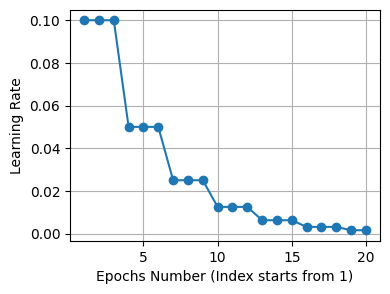

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3)), 
x_label = [ index+1 for index in range(len(lr_history))]
plt.plot(x_label, lr_history, marker='o')
plt.xlabel('Epochs Number (Index starts from 1)')
plt.ylabel('Learning Rate')

plt.grid(True)
plt.show()

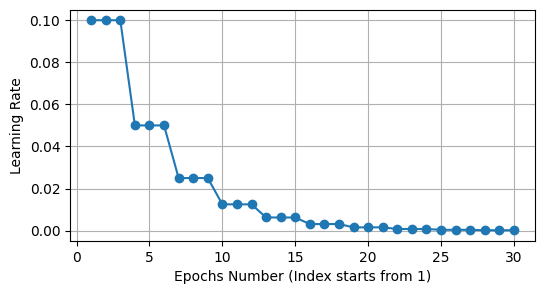

In [11]:
import matplotlib.pyplot as plt

def get_lr_history(scheduler, epochs=30, verbose=False):
  lr_history = []

  # Simulate training loop
  if verbose:
    print("Epoch\tLearning Rate")
  for epoch in range(epochs):
    if verbose:
      print(f"{epoch+1}\t{scheduler.get_last_lr()[0]:.6f}")
    lr_history.append(scheduler.get_last_lr()[0])
    scheduler.step()
  return lr_history

def draw_lr_history(lr_history, figsize=(6, 3)):
    plt.figure(figsize=figsize)
    x_label = [ index+1 for index in range(len(lr_history))]
    plt.plot(x_label, lr_history,  marker='o')
    
    plt.xlabel('Epochs Number (Index starts from 1)')
    plt.ylabel('Learning Rate')
    
    plt.grid(True)
    plt.show()

model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

lr_history = get_lr_history(scheduler=scheduler)
draw_lr_history(lr_history)


### MultiStepLR

* Adjusts the learning rate at the specific steps (epochs) defined in **milestones**.


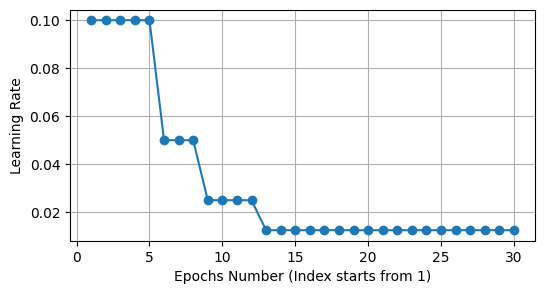

In [12]:
model = nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.1)
# This is used when you want to adjust the LR at specific points -> useful when you clearly know the plateauing pattern
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8, 12], gamma=0.5)

lr_history = get_lr_history(scheduler=scheduler) # verbose=True
draw_lr_history(lr_history)



#### CycleLR

* The learning rate repeatedly cycles between a minimum and maximum value. The LR (eta) values increase and decrease in a repeating pattern.

* **Arguments**:

  * **base\_lr**: The minimum learning rate.
  * **max\_lr**: The maximum learning rate.
  * **step\_size\_up**: Number of epochs required for the LR to increase from `base_lr` to `max_lr`.
  * **step\_size\_down**: Number of epochs required for the LR to decrease from `max_lr` back to `base_lr`.
  * **mode**: Defines the shape of the learning rate cycle. Options are:

    * **triangular**: Triangular waveform. Maximum and minimum LR remain constant across cycles.
    * **triangular2**: Triangular waveform, but the maximum LR is reduced by half after each cycle.
    * **exp\_range**: Exponential decay form, where LR decreases each epoch by a factor of `gamma`.
  * **gamma**: Multiplicative factor for LR decay applied per epoch when using `exp_range`.



Epoch	Learning Rate
1	0.001000
2	0.002800
3	0.004600
4	0.006400
5	0.008200
6	0.010000
7	0.008200
8	0.006400
9	0.004600
10	0.002800
11	0.001000
12	0.001900
13	0.002800
14	0.003700
15	0.004600
16	0.005500
17	0.004600
18	0.003700
19	0.002800
20	0.001900
21	0.001000
22	0.001450
23	0.001900
24	0.002350
25	0.002800
26	0.003250
27	0.002800
28	0.002350
29	0.001900
30	0.001450


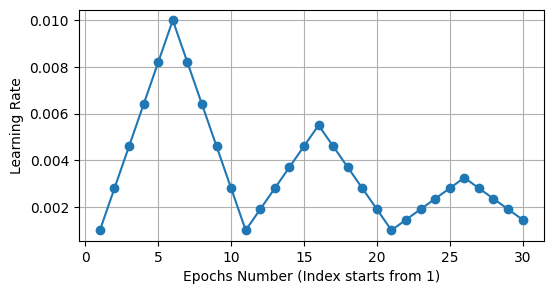

In [13]:
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,
                                            step_size_up=5,  mode='triangular2', gamma=0.9)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,
#                                             step_size_up=10, mode="exp_range", gamma=0.9)
# gamma : 
lr_history = get_lr_history(scheduler=scheduler, verbose=True)
draw_lr_history(lr_history)

#### CosineAnnealing

* The learning rate gradually decreases from the maximum to the minimum following a cosine curve, and this cosine segment is repeated periodically.

  * From maximum LR → minimum LR in a cosine-shaped decay, then repeated back to maximum → minimum.
* **T\_max**: Number of epochs for LR to go from maximum to minimum.
* **eta\_min**: Minimum learning rate.


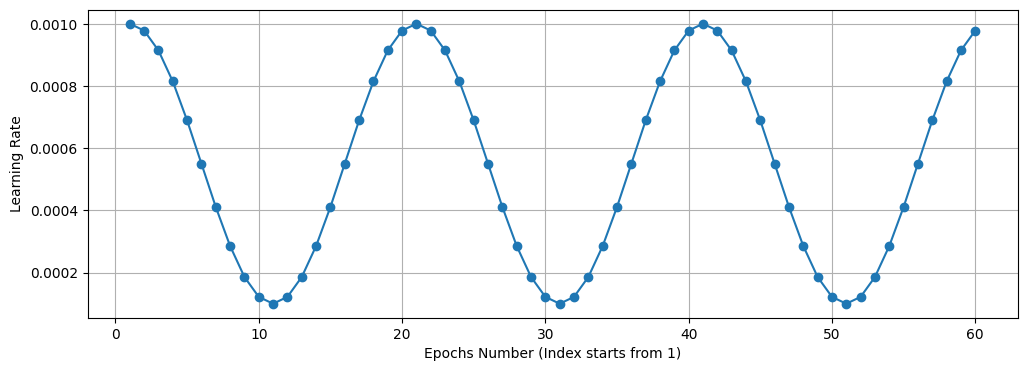

In [14]:
model = nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
lr_history = get_lr_history(scheduler=scheduler, epochs=60)
draw_lr_history(lr_history, figsize=(12, 4))

#### CosineAnnealingWarmRestarts

* Similar to **CosineAnnealing**, but at the end of each cosine iteration the number of epochs increases periodically, and the learning rate jumps directly from the minimum eta back to the maximum eta.

* **T\_0**: Number of epochs to reach the minimum LR (eta) during the first cosine iteration.

* **T\_mult**: Multiplicative factor by which the epoch length increases for each subsequent cosine iteration.

  * For example, if `T_0 = 10` and `T_mult = 2`, the first cosine iteration reaches minimum eta at 10 epochs, and the second at 30 epochs.

* **eta\_min**: Minimum learning rate (eta).

* More effective when the number of epochs is **100 or more**.


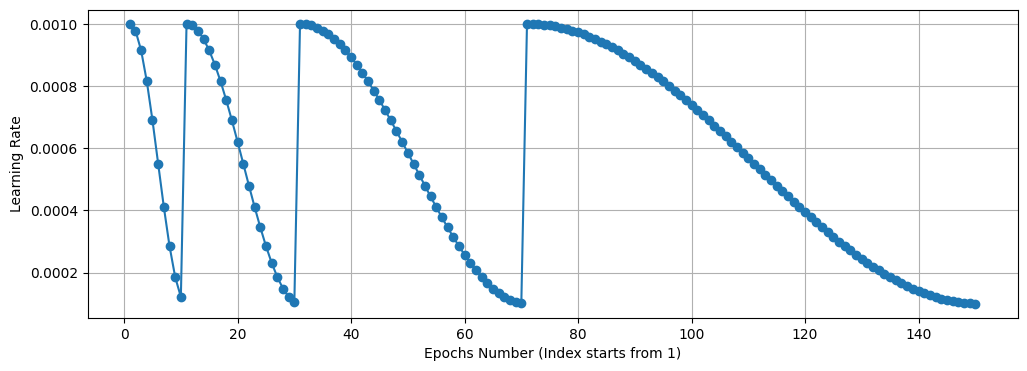

In [15]:
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.0001) #T_0를 20으로 변경
lr_history = get_lr_history(scheduler=scheduler, epochs=150)
draw_lr_history(lr_history, figsize=(12, 4))

#### Apply CosineAnnealingWarmRestarts to CNN model

In [16]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

NUM_INPUT_CHANNELS = 3
NUM_CLASSES = 10

model = SimpleCNNWithBN(num_classes=NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001) # T_max=10로 변경 후 테스트
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.0001)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=10, mode='exp_range', gamma=0.9)
trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer,
       train_loader=tr_loader, val_loader=val_loader, scheduler=scheduler, device=device)
# 학습 및 평가
history = trainer.fit(60) 

Epoch 1 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.73it/s, Loss=1.21, Accuracy=0.564]


scheduler step() call


Epoch 1 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 247.16it/s, Loss=1.11, Accuracy=0.61]


Epoch 1/60, Train Loss: 1.2063 Train Accuracy: 0.5643 , Val Loss: 1.1094 Val Accuracy: 0.6103 , Current lr:0.000978


Epoch 2 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.06it/s, Loss=0.821, Accuracy=0.711]


scheduler step() call


Epoch 2 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.96it/s, Loss=0.773, Accuracy=0.734]


Epoch 2/60, Train Loss: 0.8213 Train Accuracy: 0.7110 , Val Loss: 0.7728 Val Accuracy: 0.7339 , Current lr:0.000914


Epoch 3 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.90it/s, Loss=0.655, Accuracy=0.774]


scheduler step() call


Epoch 3 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 248.02it/s, Loss=0.681, Accuracy=0.76]


Epoch 3/60, Train Loss: 0.6546 Train Accuracy: 0.7737 , Val Loss: 0.6812 Val Accuracy: 0.7599 , Current lr:0.000815


Epoch 4 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.59it/s, Loss=0.548, Accuracy=0.812]


scheduler step() call


Epoch 4 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.98it/s, Loss=0.672, Accuracy=0.772]


Epoch 4/60, Train Loss: 0.5483 Train Accuracy: 0.8123 , Val Loss: 0.6719 Val Accuracy: 0.7723 , Current lr:0.000689


Epoch 5 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.72it/s, Loss=0.456, Accuracy=0.845]


scheduler step() call


Epoch 5 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.97it/s, Loss=0.57, Accuracy=0.804]


Epoch 5/60, Train Loss: 0.4563 Train Accuracy: 0.8446 , Val Loss: 0.5697 Val Accuracy: 0.8036 , Current lr:0.000550


Epoch 6 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.79it/s, Loss=0.374, Accuracy=0.874]


scheduler step() call


Epoch 6 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.39it/s, Loss=0.514, Accuracy=0.827]


Epoch 6/60, Train Loss: 0.3740 Train Accuracy: 0.8735 , Val Loss: 0.5140 Val Accuracy: 0.8267 , Current lr:0.000411


Epoch 7 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.41it/s, Loss=0.304, Accuracy=0.896]


scheduler step() call


Epoch 7 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 237.63it/s, Loss=0.476, Accuracy=0.837]


Epoch 7/60, Train Loss: 0.3037 Train Accuracy: 0.8965 , Val Loss: 0.4763 Val Accuracy: 0.8367 , Current lr:0.000285


Epoch 8 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.25it/s, Loss=0.243, Accuracy=0.918]


scheduler step() call


Epoch 8 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 236.77it/s, Loss=0.504, Accuracy=0.835]


Epoch 8/60, Train Loss: 0.2431 Train Accuracy: 0.9180 , Val Loss: 0.5036 Val Accuracy: 0.8353 , Current lr:0.000186


Epoch 9 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.57it/s, Loss=0.191, Accuracy=0.939]


scheduler step() call


Epoch 9 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.17it/s, Loss=0.464, Accuracy=0.849]


Epoch 9/60, Train Loss: 0.1913 Train Accuracy: 0.9389 , Val Loss: 0.4639 Val Accuracy: 0.8485 , Current lr:0.000122


Epoch 10 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.40it/s, Loss=0.159, Accuracy=0.952]


scheduler step() call


Epoch 10 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 248.29it/s, Loss=0.481, Accuracy=0.844]


Epoch 10/60, Train Loss: 0.1593 Train Accuracy: 0.9516 , Val Loss: 0.4806 Val Accuracy: 0.8436 , Current lr:0.001000


Epoch 11 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.78it/s, Loss=0.37, Accuracy=0.87]


scheduler step() call


Epoch 11 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.64it/s, Loss=0.584, Accuracy=0.812]


Epoch 11/60, Train Loss: 0.3699 Train Accuracy: 0.8700 , Val Loss: 0.5841 Val Accuracy: 0.8117 , Current lr:0.000994


Epoch 12 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.08it/s, Loss=0.307, Accuracy=0.892]


scheduler step() call


Epoch 12 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.13it/s, Loss=0.647, Accuracy=0.795]


Epoch 12/60, Train Loss: 0.3066 Train Accuracy: 0.8920 , Val Loss: 0.6469 Val Accuracy: 0.7947 , Current lr:0.000978


Epoch 13 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.17it/s, Loss=0.263, Accuracy=0.908]


scheduler step() call


Epoch 13 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 240.51it/s, Loss=0.633, Accuracy=0.81]


Epoch 13/60, Train Loss: 0.2633 Train Accuracy: 0.9076 , Val Loss: 0.6332 Val Accuracy: 0.8099 , Current lr:0.000951


Epoch 14 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.45it/s, Loss=0.232, Accuracy=0.919]


scheduler step() call


Epoch 14 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.47it/s, Loss=0.598, Accuracy=0.818]


Epoch 14/60, Train Loss: 0.2323 Train Accuracy: 0.9186 , Val Loss: 0.5984 Val Accuracy: 0.8177 , Current lr:0.000914


Epoch 15 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.75it/s, Loss=0.193, Accuracy=0.933]


scheduler step() call


Epoch 15 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 247.22it/s, Loss=0.608, Accuracy=0.822]


Epoch 15/60, Train Loss: 0.1933 Train Accuracy: 0.9331 , Val Loss: 0.6077 Val Accuracy: 0.8219 , Current lr:0.000868


Epoch 16 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.40it/s, Loss=0.165, Accuracy=0.943]


scheduler step() call


Epoch 16 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.26it/s, Loss=0.772, Accuracy=0.78]


Epoch 16/60, Train Loss: 0.1649 Train Accuracy: 0.9426 , Val Loss: 0.7722 Val Accuracy: 0.7803 , Current lr:0.000815


Epoch 17 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.99it/s, Loss=0.134, Accuracy=0.955]


scheduler step() call


Epoch 17 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.74it/s, Loss=0.579, Accuracy=0.826]


Epoch 17/60, Train Loss: 0.1336 Train Accuracy: 0.9551 , Val Loss: 0.5787 Val Accuracy: 0.8264 , Current lr:0.000754


Epoch 18 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.16it/s, Loss=0.109, Accuracy=0.964]


scheduler step() call


Epoch 18 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 240.01it/s, Loss=0.613, Accuracy=0.83]


Epoch 18/60, Train Loss: 0.1088 Train Accuracy: 0.9638 , Val Loss: 0.6126 Val Accuracy: 0.8297 , Current lr:0.000689


Epoch 19 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.31it/s, Loss=0.0839, Accuracy=0.973]


scheduler step() call


Epoch 19 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.45it/s, Loss=0.68, Accuracy=0.822]


Epoch 19/60, Train Loss: 0.0839 Train Accuracy: 0.9728 , Val Loss: 0.6798 Val Accuracy: 0.8220 , Current lr:0.000620


Epoch 20 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.23it/s, Loss=0.0667, Accuracy=0.979]


scheduler step() call


Epoch 20 [Validating]: 100%|██████████| 235/235 [00:01<00:00, 229.11it/s, Loss=0.631, Accuracy=0.836]


Epoch 20/60, Train Loss: 0.0667 Train Accuracy: 0.9790 , Val Loss: 0.6309 Val Accuracy: 0.8359 , Current lr:0.000550


Epoch 21 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.50it/s, Loss=0.0499, Accuracy=0.985]


scheduler step() call


Epoch 21 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 236.13it/s, Loss=0.664, Accuracy=0.834]


Epoch 21/60, Train Loss: 0.0499 Train Accuracy: 0.9855 , Val Loss: 0.6641 Val Accuracy: 0.8339 , Current lr:0.000480


Epoch 22 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.73it/s, Loss=0.0394, Accuracy=0.988]


scheduler step() call


Epoch 22 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 236.88it/s, Loss=0.658, Accuracy=0.84]


Epoch 22/60, Train Loss: 0.0394 Train Accuracy: 0.9883 , Val Loss: 0.6580 Val Accuracy: 0.8403 , Current lr:0.000411


Epoch 23 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 134.72it/s, Loss=0.0314, Accuracy=0.992]


scheduler step() call


Epoch 23 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.67it/s, Loss=0.656, Accuracy=0.844]


Epoch 23/60, Train Loss: 0.0314 Train Accuracy: 0.9916 , Val Loss: 0.6557 Val Accuracy: 0.8441 , Current lr:0.000346


Epoch 24 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.71it/s, Loss=0.0211, Accuracy=0.995]


scheduler step() call


Epoch 24 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.64it/s, Loss=0.656, Accuracy=0.846]


Epoch 24/60, Train Loss: 0.0211 Train Accuracy: 0.9951 , Val Loss: 0.6562 Val Accuracy: 0.8456 , Current lr:0.000285


Epoch 25 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.91it/s, Loss=0.0168, Accuracy=0.996]


scheduler step() call


Epoch 25 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.75it/s, Loss=0.703, Accuracy=0.843]


Epoch 25/60, Train Loss: 0.0168 Train Accuracy: 0.9962 , Val Loss: 0.7035 Val Accuracy: 0.8435 , Current lr:0.000232


Epoch 26 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.44it/s, Loss=0.012, Accuracy=0.998]


scheduler step() call


Epoch 26 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 241.33it/s, Loss=0.714, Accuracy=0.845]


Epoch 26/60, Train Loss: 0.0120 Train Accuracy: 0.9979 , Val Loss: 0.7138 Val Accuracy: 0.8452 , Current lr:0.000186


Epoch 27 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.25it/s, Loss=0.00918, Accuracy=0.999]


scheduler step() call


Epoch 27 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.38it/s, Loss=0.663, Accuracy=0.849]


Epoch 27/60, Train Loss: 0.0092 Train Accuracy: 0.9986 , Val Loss: 0.6633 Val Accuracy: 0.8487 , Current lr:0.000149


Epoch 28 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 138.65it/s, Loss=0.00788, Accuracy=0.999]


scheduler step() call


Epoch 28 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 240.74it/s, Loss=0.691, Accuracy=0.848]


Epoch 28/60, Train Loss: 0.0079 Train Accuracy: 0.9988 , Val Loss: 0.6914 Val Accuracy: 0.8481 , Current lr:0.000122


Epoch 29 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.54it/s, Loss=0.00686, Accuracy=0.999]


scheduler step() call


Epoch 29 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 247.83it/s, Loss=0.672, Accuracy=0.854]


Epoch 29/60, Train Loss: 0.0069 Train Accuracy: 0.9990 , Val Loss: 0.6725 Val Accuracy: 0.8537 , Current lr:0.000106


Epoch 30 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.61it/s, Loss=0.00588, Accuracy=0.999]


scheduler step() call


Epoch 30 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 247.02it/s, Loss=0.689, Accuracy=0.851]


Epoch 30/60, Train Loss: 0.0059 Train Accuracy: 0.9992 , Val Loss: 0.6885 Val Accuracy: 0.8509 , Current lr:0.001000


Epoch 31 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.70it/s, Loss=0.239, Accuracy=0.922]


scheduler step() call


Epoch 31 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.49it/s, Loss=0.747, Accuracy=0.807]


Epoch 31/60, Train Loss: 0.2393 Train Accuracy: 0.9218 , Val Loss: 0.7468 Val Accuracy: 0.8069 , Current lr:0.000999


Epoch 32 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 134.22it/s, Loss=0.0882, Accuracy=0.969]


scheduler step() call


Epoch 32 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 240.34it/s, Loss=0.853, Accuracy=0.799]


Epoch 32/60, Train Loss: 0.0882 Train Accuracy: 0.9692 , Val Loss: 0.8532 Val Accuracy: 0.7987 , Current lr:0.000994


Epoch 33 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 134.93it/s, Loss=0.0871, Accuracy=0.97]


scheduler step() call


Epoch 33 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.84it/s, Loss=0.809, Accuracy=0.811]


Epoch 33/60, Train Loss: 0.0871 Train Accuracy: 0.9700 , Val Loss: 0.8090 Val Accuracy: 0.8112 , Current lr:0.000988


Epoch 34 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.20it/s, Loss=0.0821, Accuracy=0.97]


scheduler step() call


Epoch 34 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.99it/s, Loss=0.773, Accuracy=0.819]


Epoch 34/60, Train Loss: 0.0821 Train Accuracy: 0.9704 , Val Loss: 0.7732 Val Accuracy: 0.8193 , Current lr:0.000978


Epoch 35 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.91it/s, Loss=0.0724, Accuracy=0.975]


scheduler step() call


Epoch 35 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 236.76it/s, Loss=0.75, Accuracy=0.822]


Epoch 35/60, Train Loss: 0.0724 Train Accuracy: 0.9751 , Val Loss: 0.7498 Val Accuracy: 0.8216 , Current lr:0.000966


Epoch 36 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.00it/s, Loss=0.0657, Accuracy=0.978]


scheduler step() call


Epoch 36 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.45it/s, Loss=0.761, Accuracy=0.827]


Epoch 36/60, Train Loss: 0.0657 Train Accuracy: 0.9781 , Val Loss: 0.7610 Val Accuracy: 0.8267 , Current lr:0.000951


Epoch 37 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.01it/s, Loss=0.0621, Accuracy=0.979]


scheduler step() call


Epoch 37 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.86it/s, Loss=0.74, Accuracy=0.827]


Epoch 37/60, Train Loss: 0.0621 Train Accuracy: 0.9792 , Val Loss: 0.7403 Val Accuracy: 0.8275 , Current lr:0.000934


Epoch 38 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.49it/s, Loss=0.0593, Accuracy=0.98]


scheduler step() call


Epoch 38 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.92it/s, Loss=0.825, Accuracy=0.814]


Epoch 38/60, Train Loss: 0.0593 Train Accuracy: 0.9798 , Val Loss: 0.8250 Val Accuracy: 0.8143 , Current lr:0.000914


Epoch 39 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.41it/s, Loss=0.0481, Accuracy=0.984]


scheduler step() call


Epoch 39 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.93it/s, Loss=0.774, Accuracy=0.828]


Epoch 39/60, Train Loss: 0.0481 Train Accuracy: 0.9840 , Val Loss: 0.7745 Val Accuracy: 0.8279 , Current lr:0.000892


Epoch 40 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 138.60it/s, Loss=0.0495, Accuracy=0.983]


scheduler step() call


Epoch 40 [Validating]: 100%|██████████| 235/235 [00:01<00:00, 231.79it/s, Loss=0.733, Accuracy=0.831]


Epoch 40/60, Train Loss: 0.0495 Train Accuracy: 0.9833 , Val Loss: 0.7334 Val Accuracy: 0.8313 , Current lr:0.000868


Epoch 41 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.79it/s, Loss=0.0406, Accuracy=0.987]


scheduler step() call


Epoch 41 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.18it/s, Loss=0.786, Accuracy=0.832]


Epoch 41/60, Train Loss: 0.0406 Train Accuracy: 0.9866 , Val Loss: 0.7855 Val Accuracy: 0.8316 , Current lr:0.000842


Epoch 42 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.44it/s, Loss=0.042, Accuracy=0.986]


scheduler step() call


Epoch 42 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 241.73it/s, Loss=0.902, Accuracy=0.817]


Epoch 42/60, Train Loss: 0.0420 Train Accuracy: 0.9862 , Val Loss: 0.9023 Val Accuracy: 0.8168 , Current lr:0.000815


Epoch 43 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 134.42it/s, Loss=0.04, Accuracy=0.987]


scheduler step() call


Epoch 43 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.64it/s, Loss=0.831, Accuracy=0.816]


Epoch 43/60, Train Loss: 0.0400 Train Accuracy: 0.9874 , Val Loss: 0.8312 Val Accuracy: 0.8164 , Current lr:0.000785


Epoch 44 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.02it/s, Loss=0.0309, Accuracy=0.99]


scheduler step() call


Epoch 44 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.42it/s, Loss=0.777, Accuracy=0.839]


Epoch 44/60, Train Loss: 0.0309 Train Accuracy: 0.9903 , Val Loss: 0.7770 Val Accuracy: 0.8393 , Current lr:0.000754


Epoch 45 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 138.20it/s, Loss=0.031, Accuracy=0.991]


scheduler step() call


Epoch 45 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.22it/s, Loss=0.844, Accuracy=0.823]


Epoch 45/60, Train Loss: 0.0310 Train Accuracy: 0.9905 , Val Loss: 0.8437 Val Accuracy: 0.8229 , Current lr:0.000722


Epoch 46 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.37it/s, Loss=0.0291, Accuracy=0.991]


scheduler step() call


Epoch 46 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.89it/s, Loss=0.797, Accuracy=0.834]


Epoch 46/60, Train Loss: 0.0291 Train Accuracy: 0.9908 , Val Loss: 0.7975 Val Accuracy: 0.8337 , Current lr:0.000689


Epoch 47 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.47it/s, Loss=0.0214, Accuracy=0.993]


scheduler step() call


Epoch 47 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.51it/s, Loss=0.774, Accuracy=0.841]


Epoch 47/60, Train Loss: 0.0214 Train Accuracy: 0.9933 , Val Loss: 0.7744 Val Accuracy: 0.8412 , Current lr:0.000655


Epoch 48 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.64it/s, Loss=0.0225, Accuracy=0.993]


scheduler step() call


Epoch 48 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.02it/s, Loss=0.836, Accuracy=0.831]


Epoch 48/60, Train Loss: 0.0225 Train Accuracy: 0.9933 , Val Loss: 0.8357 Val Accuracy: 0.8305 , Current lr:0.000620


Epoch 49 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.48it/s, Loss=0.0196, Accuracy=0.994]


scheduler step() call


Epoch 49 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 237.19it/s, Loss=0.875, Accuracy=0.834]


Epoch 49/60, Train Loss: 0.0196 Train Accuracy: 0.9938 , Val Loss: 0.8750 Val Accuracy: 0.8337 , Current lr:0.000585


Epoch 50 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 138.04it/s, Loss=0.0169, Accuracy=0.995]


scheduler step() call


Epoch 50 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 238.35it/s, Loss=0.814, Accuracy=0.836]


Epoch 50/60, Train Loss: 0.0169 Train Accuracy: 0.9948 , Val Loss: 0.8142 Val Accuracy: 0.8360 , Current lr:0.000550


Epoch 51 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.16it/s, Loss=0.0144, Accuracy=0.996]


scheduler step() call


Epoch 51 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.76it/s, Loss=0.824, Accuracy=0.839]


Epoch 51/60, Train Loss: 0.0144 Train Accuracy: 0.9957 , Val Loss: 0.8239 Val Accuracy: 0.8392 , Current lr:0.000515


Epoch 52 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.99it/s, Loss=0.0165, Accuracy=0.995]


scheduler step() call


Epoch 52 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 248.92it/s, Loss=0.783, Accuracy=0.84]


Epoch 52/60, Train Loss: 0.0165 Train Accuracy: 0.9953 , Val Loss: 0.7825 Val Accuracy: 0.8400 , Current lr:0.000480


Epoch 53 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.86it/s, Loss=0.0091, Accuracy=0.998]


scheduler step() call


Epoch 53 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.46it/s, Loss=0.783, Accuracy=0.845]


Epoch 53/60, Train Loss: 0.0091 Train Accuracy: 0.9978 , Val Loss: 0.7829 Val Accuracy: 0.8447 , Current lr:0.000445


Epoch 54 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.00it/s, Loss=0.00947, Accuracy=0.997]


scheduler step() call


Epoch 54 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.30it/s, Loss=0.82, Accuracy=0.84]


Epoch 54/60, Train Loss: 0.0095 Train Accuracy: 0.9975 , Val Loss: 0.8197 Val Accuracy: 0.8401 , Current lr:0.000411


Epoch 55 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.33it/s, Loss=0.00861, Accuracy=0.998]


scheduler step() call


Epoch 55 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.89it/s, Loss=0.82, Accuracy=0.841]


Epoch 55/60, Train Loss: 0.0086 Train Accuracy: 0.9977 , Val Loss: 0.8199 Val Accuracy: 0.8408 , Current lr:0.000378


Epoch 56 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.28it/s, Loss=0.00597, Accuracy=0.999]


scheduler step() call


Epoch 56 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.09it/s, Loss=0.794, Accuracy=0.841]


Epoch 56/60, Train Loss: 0.0060 Train Accuracy: 0.9987 , Val Loss: 0.7938 Val Accuracy: 0.8412 , Current lr:0.000346


Epoch 57 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.64it/s, Loss=0.00526, Accuracy=0.999]


scheduler step() call


Epoch 57 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.78it/s, Loss=0.819, Accuracy=0.847]


Epoch 57/60, Train Loss: 0.0053 Train Accuracy: 0.9989 , Val Loss: 0.8193 Val Accuracy: 0.8467 , Current lr:0.000315


Epoch 58 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 135.43it/s, Loss=0.00594, Accuracy=0.999]


scheduler step() call


Epoch 58 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 241.09it/s, Loss=0.81, Accuracy=0.848]


Epoch 58/60, Train Loss: 0.0059 Train Accuracy: 0.9986 , Val Loss: 0.8103 Val Accuracy: 0.8481 , Current lr:0.000285


Epoch 59 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 136.85it/s, Loss=0.00347, Accuracy=0.999]


scheduler step() call


Epoch 59 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.44it/s, Loss=0.809, Accuracy=0.849]


Epoch 59/60, Train Loss: 0.0035 Train Accuracy: 0.9993 , Val Loss: 0.8090 Val Accuracy: 0.8491 , Current lr:0.000258


Epoch 60 [Training..]: 100%|██████████| 1329/1329 [00:09<00:00, 137.42it/s, Loss=0.00296, Accuracy=1]


scheduler step() call


Epoch 60 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.84it/s, Loss=0.825, Accuracy=0.847]

Epoch 60/60, Train Loss: 0.0030 Train Accuracy: 0.9996 , Val Loss: 0.8254 Val Accuracy: 0.8465 , Current lr:0.000232


In [17]:
trained_model = trainer.get_trained_model()

predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:01<00:00, 249.91it/s, Accuracy=0.844]

test dataset evaluation:0.8443


### Weight Decay

* Applies **weight regularization**. Increasing its value can reduce overfitting, but may also cause underfitting. If the value is too small, its effect on reducing overfitting will be minimal.
* It is set as a parameter (`weight_decay`) when creating the **optimizer**. Typically, values between **1e-2 and 1e-3** are used.
* When applying weight decay, it is generally more effective to use **AdamW** than Adam.


In [18]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

NUM_INPUT_CHANNELS = 3
NUM_CLASSES = 10

model = SimpleCNNWithBN(num_classes=NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-2) #weight_decay=1e-3 
loss_fn = nn.CrossEntropyLoss()

scheduler = ReduceLROnPlateau(
            optimizer=optimizer, mode='min', factor=0.5, patience=2, threshold=0.01, min_lr=0.00001)

trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer,
       train_loader=tr_loader, val_loader=val_loader, scheduler=scheduler, device=device)

history = trainer.fit(30)

Epoch 1 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.99it/s, Loss=1.1, Accuracy=0.606]


scheduler step(evaluation_value) call
Epoch 1/30, Train Loss: 1.2273 Train Accuracy: 0.5546 , Val Loss: 1.0998 Val Accuracy: 0.6061 , Current lr:0.001000


Epoch 2 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.63it/s, Loss=0.776, Accuracy=0.731]


scheduler step(evaluation_value) call
Epoch 2/30, Train Loss: 0.8530 Train Accuracy: 0.7006 , Val Loss: 0.7762 Val Accuracy: 0.7305 , Current lr:0.001000


Epoch 3 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.59it/s, Loss=0.781, Accuracy=0.731]


scheduler step(evaluation_value) call
Epoch 3/30, Train Loss: 0.6898 Train Accuracy: 0.7595 , Val Loss: 0.7807 Val Accuracy: 0.7315 , Current lr:0.001000


Epoch 4 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.65it/s, Loss=0.732, Accuracy=0.745]


scheduler step(evaluation_value) call
Epoch 4/30, Train Loss: 0.5862 Train Accuracy: 0.7961 , Val Loss: 0.7315 Val Accuracy: 0.7447 , Current lr:0.001000


Epoch 5 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.26it/s, Loss=0.566, Accuracy=0.803]


scheduler step(evaluation_value) call
Epoch 5/30, Train Loss: 0.5071 Train Accuracy: 0.8236 , Val Loss: 0.5662 Val Accuracy: 0.8029 , Current lr:0.001000


Epoch 6 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.80it/s, Loss=0.749, Accuracy=0.754]


scheduler step(evaluation_value) call
Epoch 6/30, Train Loss: 0.4467 Train Accuracy: 0.8448 , Val Loss: 0.7485 Val Accuracy: 0.7544 , Current lr:0.001000


Epoch 7 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 247.10it/s, Loss=0.547, Accuracy=0.817]


scheduler step(evaluation_value) call
Epoch 7/30, Train Loss: 0.3904 Train Accuracy: 0.8653 , Val Loss: 0.5471 Val Accuracy: 0.8167 , Current lr:0.001000


Epoch 8 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 247.36it/s, Loss=0.587, Accuracy=0.809]


scheduler step(evaluation_value) call
Epoch 8/30, Train Loss: 0.3454 Train Accuracy: 0.8833 , Val Loss: 0.5865 Val Accuracy: 0.8089 , Current lr:0.001000


Epoch 9 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 237.09it/s, Loss=0.651, Accuracy=0.789]


scheduler step(evaluation_value) call
Epoch 9/30, Train Loss: 0.3085 Train Accuracy: 0.8939 , Val Loss: 0.6508 Val Accuracy: 0.7895 , Current lr:0.001000


Epoch 10 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 240.14it/s, Loss=0.646, Accuracy=0.804]


scheduler step(evaluation_value) call
Epoch 10/30, Train Loss: 0.2634 Train Accuracy: 0.9090 , Val Loss: 0.6460 Val Accuracy: 0.8039 , Current lr:0.000500


Epoch 11 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.24it/s, Loss=0.514, Accuracy=0.845]


scheduler step(evaluation_value) call
Epoch 11/30, Train Loss: 0.1565 Train Accuracy: 0.9512 , Val Loss: 0.5135 Val Accuracy: 0.8448 , Current lr:0.000500


Epoch 12 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.88it/s, Loss=0.525, Accuracy=0.847]


scheduler step(evaluation_value) call
Epoch 12/30, Train Loss: 0.1312 Train Accuracy: 0.9578 , Val Loss: 0.5247 Val Accuracy: 0.8469 , Current lr:0.000500


Epoch 13 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 239.18it/s, Loss=0.54, Accuracy=0.844]


scheduler step(evaluation_value) call
Epoch 13/30, Train Loss: 0.1040 Train Accuracy: 0.9669 , Val Loss: 0.5398 Val Accuracy: 0.8440 , Current lr:0.000500


Epoch 14 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.25it/s, Loss=0.561, Accuracy=0.843]


scheduler step(evaluation_value) call
Epoch 14/30, Train Loss: 0.0895 Train Accuracy: 0.9729 , Val Loss: 0.5614 Val Accuracy: 0.8425 , Current lr:0.000250


Epoch 15 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.94it/s, Loss=0.534, Accuracy=0.852]


scheduler step(evaluation_value) call
Epoch 15/30, Train Loss: 0.0542 Train Accuracy: 0.9867 , Val Loss: 0.5344 Val Accuracy: 0.8519 , Current lr:0.000250


Epoch 16 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.37it/s, Loss=0.545, Accuracy=0.854]


scheduler step(evaluation_value) call
Epoch 16/30, Train Loss: 0.0405 Train Accuracy: 0.9910 , Val Loss: 0.5453 Val Accuracy: 0.8537 , Current lr:0.000250


Epoch 17 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.40it/s, Loss=0.574, Accuracy=0.847]


scheduler step(evaluation_value) call
Epoch 17/30, Train Loss: 0.0352 Train Accuracy: 0.9927 , Val Loss: 0.5736 Val Accuracy: 0.8471 , Current lr:0.000125


Epoch 18 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.95it/s, Loss=0.573, Accuracy=0.85]


scheduler step(evaluation_value) call
Epoch 18/30, Train Loss: 0.0229 Train Accuracy: 0.9967 , Val Loss: 0.5726 Val Accuracy: 0.8501 , Current lr:0.000125


Epoch 19 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.11it/s, Loss=0.576, Accuracy=0.853]


scheduler step(evaluation_value) call
Epoch 19/30, Train Loss: 0.0200 Train Accuracy: 0.9972 , Val Loss: 0.5761 Val Accuracy: 0.8525 , Current lr:0.000125


Epoch 20 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 241.85it/s, Loss=0.605, Accuracy=0.85]


scheduler step(evaluation_value) call
Epoch 20/30, Train Loss: 0.0180 Train Accuracy: 0.9979 , Val Loss: 0.6053 Val Accuracy: 0.8503 , Current lr:0.000063


Epoch 21 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 238.81it/s, Loss=0.589, Accuracy=0.855]


scheduler step(evaluation_value) call
Epoch 21/30, Train Loss: 0.0139 Train Accuracy: 0.9989 , Val Loss: 0.5887 Val Accuracy: 0.8552 , Current lr:0.000063


Epoch 22 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 238.67it/s, Loss=0.617, Accuracy=0.851]


scheduler step(evaluation_value) call
Epoch 22/30, Train Loss: 0.0124 Train Accuracy: 0.9989 , Val Loss: 0.6172 Val Accuracy: 0.8515 , Current lr:0.000063


Epoch 23 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.43it/s, Loss=0.603, Accuracy=0.853]


scheduler step(evaluation_value) call
Epoch 23/30, Train Loss: 0.0120 Train Accuracy: 0.9989 , Val Loss: 0.6029 Val Accuracy: 0.8528 , Current lr:0.000031


Epoch 24 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.19it/s, Loss=0.611, Accuracy=0.852]


scheduler step(evaluation_value) call
Epoch 24/30, Train Loss: 0.0098 Train Accuracy: 0.9994 , Val Loss: 0.6106 Val Accuracy: 0.8519 , Current lr:0.000031


Epoch 25 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.60it/s, Loss=0.607, Accuracy=0.855]


scheduler step(evaluation_value) call
Epoch 25/30, Train Loss: 0.0094 Train Accuracy: 0.9993 , Val Loss: 0.6073 Val Accuracy: 0.8547 , Current lr:0.000031


Epoch 26 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 236.08it/s, Loss=0.617, Accuracy=0.851]


scheduler step(evaluation_value) call
Epoch 26/30, Train Loss: 0.0116 Train Accuracy: 0.9993 , Val Loss: 0.6173 Val Accuracy: 0.8508 , Current lr:0.000016


Epoch 27 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 246.00it/s, Loss=0.616, Accuracy=0.854]


scheduler step(evaluation_value) call
Epoch 27/30, Train Loss: 0.0079 Train Accuracy: 0.9998 , Val Loss: 0.6158 Val Accuracy: 0.8544 , Current lr:0.000016


Epoch 28 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 249.25it/s, Loss=0.624, Accuracy=0.853]


scheduler step(evaluation_value) call
Epoch 28/30, Train Loss: 0.0081 Train Accuracy: 0.9996 , Val Loss: 0.6242 Val Accuracy: 0.8527 , Current lr:0.000016


Epoch 29 [Validating]: 100%|██████████| 235/235 [00:01<00:00, 212.01it/s, Loss=0.615, Accuracy=0.852]


scheduler step(evaluation_value) call
Epoch 29/30, Train Loss: 0.0093 Train Accuracy: 0.9994 , Val Loss: 0.6145 Val Accuracy: 0.8520 , Current lr:0.000010


Epoch 30 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.12it/s, Loss=0.615, Accuracy=0.854]

scheduler step(evaluation_value) call
Epoch 30/30, Train Loss: 0.0080 Train Accuracy: 0.9996 , Val Loss: 0.6148 Val Accuracy: 0.8537 , Current lr:0.000010


In [19]:
trained_model = trainer.get_trained_model()

predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:01<00:00, 247.93it/s, Accuracy=0.846]

test dataset evaluation:0.8455
